## Multiclass text classification

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
import joblib
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/amit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#load the train data
df = pd.read_csv('train_set.csv')

In [3]:
df.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for c...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...
3,85389000,lv na p trip unit for cvs switch parts of circ...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...


In [4]:
#train set size
df.shape

(23615, 2)

In [5]:
#checking column types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23615 entries, 0 to 23614
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   23615 non-null  int64 
 1   text    23615 non-null  object
dtypes: int64(1), object(1)
memory usage: 369.1+ KB


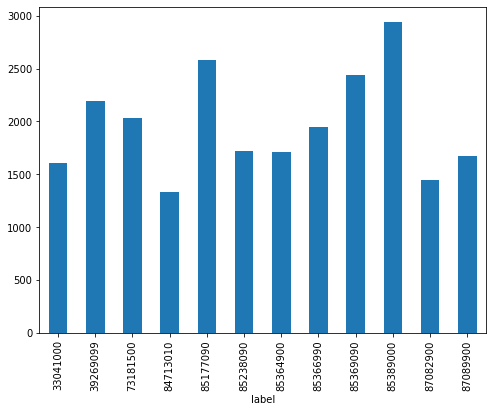

In [6]:
#plotting  class distribution
fig = plt.figure(figsize=(8,6))
df.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

## Data Preprocessing

In [7]:
#covert the text to lowercase
df.text = df.text.str.lower()

In [8]:
#check if column has missing values
df.isna().any()

label    False
text     False
dtype: bool

In [9]:
# remove punctuations if any 
df["text"] = df['text'].str.replace('[^\w\s]','')
#remove special characters if any
df['text'] = df['text'].str.replace('[^A-Za-z0-9]+', ' ')


/home/amit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/home/amit/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [10]:
print(df['text'][0])

print(df['text'][24])

print(df['text'][30])

 pdscpm gb part of panel of chiller
medium xa pilot lightv acgreen xaevflc
parts for programmable logic controllers ac parts for plcs printed circuit assembl coo at


In [11]:
#refrence  https://stackoverflow.com/a/47091490/4084039
# decontract contracted words in longer form
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


In [12]:
#decontracting words
df['text'] = df['text'].apply(decontracted)

In [13]:
df['text'][555]

' touch panel screen rsc hmisto'

In [14]:
#stripping white spaces from strings
df['text']=df['text'].str.strip()

In [15]:
#counting frequecy of words in dataset
words = nltk.tokenize.word_tokenize(df['text'].str.cat(sep=' '))
word_dist = nltk.FreqDist(words)
print('total unique words in raw text',len(word_dist))
word_dist.most_common(30)

total unique words in raw text 13924


[('for', 12096),
 ('parts', 5009),
 ('no', 3739),
 ('p', 3112),
 ('captive', 2932),
 ('consumption', 2815),
 ('g', 2658),
 ('a', 2499),
 ('part', 2344),
 ('automotive', 2243),
 ('connector', 2006),
 ('use', 1656),
 ('dvd', 1624),
 ('issue', 1622),
 ('esitronic', 1594),
 ('lip', 1585),
 ('list', 1565),
 ('of', 1531),
 ('each', 1530),
 ('sale', 1520),
 ('pcs', 1438),
 ('gmoz', 1437),
 ('v', 1396),
 ('mobile', 1393),
 ('not', 1392),
 ('non', 1336),
 ('phone', 1289),
 ('ac', 1233),
 ('b', 1131),
 ('equipment', 1131)]

In [16]:
# remove stop words from the text
stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [17]:
# reving stop words
preprocessed_text = []
for text in df['text'].values:
    text =  ' '.join(e.lower() for e in text.split() if e.lower() not in stopwords)
    preprocessed_text.append(text)

In [18]:
preprocessed_text[15]

'sdar thermomagnetic release threepole acdc tmar la parts circuit breaker'

In [19]:
df['text_preprocessed'] = preprocessed_text
df.head()

,label,text,text_preprocessed
0,85389000,pdscpm gb part of panel of chiller,pdscpm gb part panel chiller
1,85389000,nm p economical extended rot hand parts for ci...,nm p economical extended rot hand parts circui...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...,lv pd trip unit cvs parts circuit breakers
3,85389000,lv na p trip unit for cvs switch parts of circ...,lv na p trip unit cvs switch parts circuit bre...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...,lv tmd pd trip unit cvs parts circuitbreakers


In [20]:
#checking word frquency after removing stopwords
words = nltk.tokenize.word_tokenize(df['text_preprocessed'].str.cat(sep=' '))
word_dist = nltk.FreqDist(words)
print('total unique words after removing stopwords',len(word_dist))
word_dist.most_common(30)

total unique words after removing stopwords 13852


[('parts', 5009),
 ('no', 3739),
 ('p', 3112),
 ('captive', 2932),
 ('consumption', 2815),
 ('g', 2658),
 ('part', 2344),
 ('automotive', 2243),
 ('connector', 2006),
 ('use', 1656),
 ('dvd', 1624),
 ('issue', 1622),
 ('esitronic', 1594),
 ('lip', 1585),
 ('list', 1565),
 ('sale', 1520),
 ('pcs', 1438),
 ('gmoz', 1437),
 ('v', 1396),
 ('mobile', 1393),
 ('not', 1392),
 ('non', 1336),
 ('phone', 1289),
 ('ac', 1233),
 ('b', 1131),
 ('equipment', 1131),
 ('screw', 1088),
 ('x', 1067),
 ('sl', 1041),
 ('makeup', 980)]

In [21]:
##split the data to train and val-set 
X_train,X_test,y_train,y_test = train_test_split(df['text_preprocessed'],df['label'],test_size=0.25,stratify=df['label'])
X_train

21300    cvr frt bmpr lwr cover front bumper lower ebbf...
18050    qe track control arm complete automotive parts...
7099     terminal connection contact elements wires cab...
10072                absorber strip ft frim hr antenna pcs
13859              pnsi connector list sl pf cable harness
                               ...                        
14682                           gsabe dcsqgsegrelay vdclsn
3624     non lte card alaa sr noyp matrixe partsfor sdh...
2757     ladn auxiliary contact block tesys no nc screw...
16744                      issue esitronic dvd b part no p
8867                        eye brown mm rc pc c toys eyes
Name: text_preprocessed, Length: 17711, dtype: object

In [22]:
print('total samples in train set',X_train.shape[0])
print('total samples in val set',X_test.shape[0])

total samples in train set 17711
total samples in val set 5904


## Using TF-IDF for text vectorization

In [23]:
# fitting the vectorizer only on text data
tf_idf_vect = TfidfVectorizer(sublinear_tf=True,min_df=5)
tf_idf_vect.fit(X_train)
final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (17711, 2458)
the number of unique words including both unigrams 2458


In [24]:
X_train = final_tf_idf.toarray()

In [25]:
#vecotrizing X_test
X_test = tf_idf_vect.transform(X_test).toarray()

In [27]:
NaiveBayes = MultinomialNB()
NaiveBayes.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [29]:
print('train accuracy',NaiveBayes.score(X_train,y_train))
print('valset accuracy',NaiveBayes.score(X_test,y_test))

train accuracy 0.8959403760374908
valset accuracy 0.8741531165311653


In [30]:
y_pred = NaiveBayes.predict(X_test)

In [31]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS for Naive Bayes\n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS for Naive Bayes

              precision    recall  f1-score   support

    33041000       0.99      1.00      1.00       401
    39269099       0.82      0.80      0.81       547
    73181500       0.87      0.87      0.87       508
    84713010       0.99      0.98      0.98       333
    85177090       0.95      0.95      0.95       645
    85238090       0.99      0.98      0.98       430
    85364900       0.85      0.95      0.90       429
    85366990       0.80      0.83      0.82       486
    85369090       0.80      0.70      0.75       610
    85389000       0.82      0.86      0.84       734
    87082900       0.88      0.87      0.88       363
    87089900       0.82      0.80      0.81       418

    accuracy                           0.87      5904
   macro avg       0.88      0.88      0.88      5904
weighted avg       0.87      0.87      0.87      5904



In [33]:
#using Random Forest Model Number of trees in random forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 10)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [x for x in range(2,10,2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

In [34]:
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)
weights = compute_class_weight('balanced',df['label'].unique(),y_train)
weights

{'n_estimators': [50, 66, 83, 100, 116, 133, 150, 166, 183, 200], 'max_depth': [2, 4, 6, 8, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True]}


array([0.67026188, 0.76235365, 0.80739424, 0.89885302, 0.96781421,
       1.01228852, 1.14857328, 1.14412145, 1.17602922, 1.22584441,
       1.35654105, 1.47887442])

In [35]:
rf_Model = RandomForestClassifier(class_weight='balanced',max_features=None)
rf = RandomizedSearchCV(estimator = rf_Model, param_distributions = param_grid, cv = 5, verbose=10, n_jobs = 6)
rf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  9.3min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 26.1min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 40.6min
[Parallel(n_jobs=6)]: Done  45 out of  50 | elapsed: 47.5min remaining:  5.3min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed: 60.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
           

In [42]:
best_para = rf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': None,
 'bootstrap': True}

In [86]:
print("Random Forest train accuract",round(rf.score(X_train,y_train),4))
print('Random Forest val accuracy',round(rf.score(X_test,y_test),4))

train accuract 0.9855
val accuracy 0.9258


In [48]:
y_pred = rf.predict(X_test)
print('\t\t\t\tCLASSIFICATIION METRICS for Random Forest \n')
print(metrics.classification_report(y_test, y_pred))

				CLASSIFICATIION METRICS for Random Forest 

              precision    recall  f1-score   support

    33041000       1.00      1.00      1.00       401
    39269099       0.86      0.89      0.88       547
    73181500       0.93      0.90      0.92       508
    84713010       0.98      0.98      0.98       333
    85177090       0.96      0.97      0.96       645
    85238090       1.00      0.99      0.99       430
    85364900       0.97      0.98      0.97       429
    85366990       0.79      0.89      0.84       486
    85369090       0.89      0.89      0.89       610
    85389000       0.96      0.89      0.92       734
    87082900       0.95      0.91      0.93       363
    87089900       0.89      0.89      0.89       418

    accuracy                           0.93      5904
   macro avg       0.93      0.93      0.93      5904
weighted avg       0.93      0.93      0.93      5904



### Evaluating on the final test set

In [49]:
test_df = pd.read_csv('test_set.csv')

In [50]:
test_df.head()

,text
0,lv tmd pd trip unit for nh parts of circuit br...
1,module tm analog outputs analog output expansi...
2,command group t iii mechanismt p parts forcir...
3,parts of relayelectrical contact issu e f xxup
4,parts for programmable logic controllers dm ...


In [51]:
test_df.shape

(5894, 1)

In [58]:
#apply preprocessing to the test_set

def preprocessor(text):
    text = text.lower()
    #remove punctuations
    text = re.sub('[^\w\s]','',text)
    #remove special chars
    text = re.sub('[^A-Za-z0-9]+', ' ',text)
    #strip extra spaces on left right
    text = text.strip()
    #decontract words
    text = decontracted(text)
    #remove stop words
    text = ' '.join(e for e in text.split() if e not in stopwords)
    return text

In [59]:
processed_text = test_df['text'].apply(preprocessor)

In [69]:
processed_text.shape

(5894,)

In [72]:
# generating vectors from text
test_X = tf_idf_vect.transform(processed_text).toarray()

In [73]:
#shape of tf-idf vector for the test set
test_X.shape

(5894, 2458)

In [74]:
y_pred = rf.predict(test_X)

In [77]:
test_df['label']= y_pred

In [80]:
test_df.head()

,text,label
0,lv tmd pd trip unit for nh parts of circuit br...,85389000
1,module tm analog outputs analog output expansi...,85389000
2,command group t iii mechanismt p parts forcir...,39269099
3,parts of relayelectrical contact issu e f xxup,85389000
4,parts for programmable logic controllers dm ...,85389000


In [83]:
#saving the predections to csv file
test_df.to_csv('test_set_with_predections.csv',index=False)

# Saving Models and the vectorizer 

In [90]:
# saving random forest model
joblib.dump(rf, 'rf_classifier.pkl') 

['rf_classifier.pkl']

In [91]:
joblib.dump(tf_idf_vect,'tfidf_vector.pkl')

['tfidf_vector.pkl']